In [31]:
#import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn import preprocessing
from sklearn.utils import class_weight
import os
import sys
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#from models import CNNQuantized
#from models import ConvNet_smaller1
# from models import ConvNet_300k
# from models import ConvNet_144k
# from models import ConvNet_580k
from models import ConvNet_200k

In [32]:
# audio 8000 x 16000 -> (librosa -> 8000x20x126) not quantized -> train a classifer -> validation : 94%
#  y  80000 x 20 (num of label)


# audio 8000 x 16000 -> (librosa -> 8000x20x126) quantize -> train a classifer -> validation : 70%
#  y  80000 x 20 (num of label)

# audio 8000 x 16000 -> model (predict quantized librosa) -> 8000x20x126 -> a classifer -> output: 70%

In [33]:
#hypothesis: for accuracy we don't think it matters if we use full frame or single frame. 

In [34]:
class MFCCDNN(nn.Module):
	def __init__(self):
		super().__init__()
		self.ln1 = nn.Linear(256, 228)
		self.ln2 = nn.Linear(228, 200)
		self.ln3 = nn.Linear(200, 164)
		self.ln4 = nn.Linear(164, 20)
# 		self.ln5 = nn.Linear(128, 20)
# 		self.ln6 = nn.Linear(64, 32)
# 		self.ln7 = nn.Linear(32, 20)


		self.ln11 = nn.Linear(256, 256)
		self.ln12 = nn.Linear(256, 20)








	#forward propogation
	def forward(self, x):
		x = F.relu(self.ln1(x))
		x = F.relu(self.ln2(x))
		x = F.relu(self.ln3(x))
# 		x = F.relu(self.ln4(x))
# 		x = F.relu(self.ln5(x)) 
# 		x = F.relu(self.ln6(x))
		x = self.ln4(x)

		return x

In [35]:

directory = 'C:/Users/hdfer/OneDrive/Desktop/MFCC_Estimator/final_model_20_words/'
net = MFCCDNN()
#conv_net = CNNQuantized()
conv_net = ConvNet_200k()

from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\cnn_classifier_trimming\nn05_quantized_200k_params.pt', map_location=torch.device('cpu'))
# for k, v in state_dict.items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# load params
conv_net.load_state_dict(state_dict)

# conv_net.load_state_dict(torch.load(directory+'nn05_quantized.pt', map_location=torch.device('cpu')))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('param count DNN:', count_parameters(net))
print('param count CNN:', count_parameters(conv_net))
print('total param count: ', count_parameters(net) + count_parameters(conv_net))

param count DNN: 211592
param count CNN: 201207
total param count:  412799


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
if torch.cuda.device_count() > 1:
  net = nn.DataParallel(net)
net.to(device)
conv_net.to(device)

ConvNet_200k(
  (conv1): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(26, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_fc): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4960, out_features=21, bias=True)
)

In [7]:
labels20 = np.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\final_model_20_words\test_label_sf20.npy')
labels20.shape

(8181,)

In [8]:
np.unique(labels20)

array(['down', 'eight', 'five', 'four', 'go', 'left', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up',
       'yes', 'zero'], dtype='<U10')

In [9]:
X_train = np.load(directory + 'train_audio_sf20.npy')
#y_train = np.load(directory+'train_mfcc_sf2.npy')
# y_train = np.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\quantized\y_train_quant.npy')


y_train = np.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\quantized\X_train_quant.npy')
train_label = np.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\quantized\y_train_quant.npy')
# indx = (train_label == 'one') | (train_label == 'two') | (train_label == 'three') | (train_label == 'four') | (train_label =='five')
# y_train = y_train[indx,]

# l1 = ['one']
# l1 = l1 * 3140
# l2 = ['two']
# l2 = l2 * 3111
# train_class = l1 + l2

X_test = np.load(directory+'test_audio_sf20.npy')
#y_test = np.load(directory+'test_mfcc_sf2.npy') # low resolution mfcc
#test_label = np.load(directory+'test_label_sf2.npy')

y_test = np.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\quantized\X_test_quant.npy')
test_label = np.load(r'C:\Users\hdfer\OneDrive\Desktop\MFCC_Estimator\quantized\y_test_quant.npy')
# indx = (test_label == 'one') | (test_label == 'two') | (test_label == 'three') | (test_label == 'four') | (test_label =='five')
# y_test = y_test[indx,]
# test_label = test_label[indx]

In [10]:
X_test.shape

(8181, 16000)

In [11]:
X_train.shape

(61927, 16000)

In [12]:
np.unique(test_label)

array(['down', 'eight', 'five', 'four', 'go', 'left', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up',
       'yes', 'zero'], dtype='<U10')

this notebook is taking unquantized audio and learning the quantized mfccs and still works at 95%

is it possible we shuffled X_train and y_train and they're not aligned?

check how train / test_mfcc_sf2 were generated and see if they were sliced properly

for example we do line 23 in the cell above, did we do that the same way in generating sf2 data?

In [13]:
np.unique(test_label)

array(['down', 'eight', 'five', 'four', 'go', 'left', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up',
       'yes', 'zero'], dtype='<U10')

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(61927, 16000)
(61927, 20, 126)
(8181, 16000)
(8181, 20, 126)


In [15]:
import matplotlib.pyplot as plt

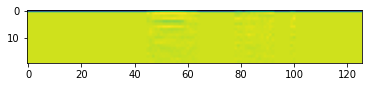

In [16]:
plt.imshow(y_test[0])

In [17]:
def reshape(data, hop_length=128, clip_size=256):
  dim0 = int(((data.shape[1] * 2) + clip_size) * (data.shape[0] / clip_size))
  new = np.zeros((dim0, clip_size))
  j_max = int((data.shape[1] / hop_length))
  for i in range(data.shape[0]):
      for j in range(j_max + 1):
          indx = int(j+(i*(clip_size/2 - 2)))
          if (j == (j_max)):
              new[indx] = np.zeros((clip_size))
          elif (j == (j_max-1)):
              temp = np.zeros(clip_size)
              temp[0:int(clip_size/2)] = data[i, (j*hop_length):((j*hop_length) + int((clip_size/2)))]
              new[indx] = temp
          else:
              new[indx] = data[i, (j*hop_length):(j*hop_length+clip_size)]
  return new

def flatten_data(data):
  # t = y_train[:2]
  c = 0
  flat_data = np.zeros((data.shape[0] * data.shape[2], data.shape[1]))
  # print(y_n.shape)
  for i in range(data.shape[0]):
    for k in range(data.shape[2]):
      # print(t[i, :, k].shape)
      flat_data[c] = data[i, :, k]
      c+=1
  # print(data.shape)
  # flat_data = np.reshape(data, (data.shape[0] * data.shape[2], data.shape[1]), order='F')
  return flat_data

In [18]:
X_train = reshape(X_train)
X_test = reshape(X_test)
y_train = flatten_data(y_train)
y_test = flatten_data(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7802802, 256)
(7802802, 20)
(1030806, 256)
(1030806, 20)


In [19]:
X_train = torch.from_numpy(X_train)

print(X_train.element_size() * X_train.nelement())
le = preprocessing.LabelEncoder()
le.classes_ = np.load(directory+'encoder.npy')
# y_train = le.fit_transform(y_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
test_label = le.transform(test_label)
y_test = torch.from_numpy(y_test)

15980138496


In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

#create dataloaders for all 3 datasets

print(X_train.shape)
print(y_train.shape)

train_set = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_set, batch_size = 126, num_workers = 2, shuffle=True)


test_set = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_set, batch_size = 126, num_workers = 2)

torch.Size([7802802, 256])
torch.Size([7802802, 20])


# SKIP CELL BELOW: 

In [21]:
count = 0
for epoch in range(30):
  print(epoch)
  running_loss = 0.0

  for i, data in enumerate(train_dataloader):
    #get input data and labels
    inputs, labels = data

    #labels need to be LongTensor type for some reason
    labels = labels.type(torch.FloatTensor)

    #inputs need to be floats
    inputs = inputs.float()

    #reshape inputs as (channels, batch size, 20, 126)
    #(20, 126) at end should be constant due to our preprocessing of the
    #MFCCs
    # inputs = torch.reshape(inputs, (1, inputs.shape[0], 16000))
    # inputs = torch.permute(inputs, (1, 0))

    #send data to gpus
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(inputs.size())
    # print(labels.size())
    #zero the gradients in optimizer
    optimizer.zero_grad()

    #create predictions, calculate loss, backward propogation, then
    #update weights of model
    outputs = net(inputs)
    if(torch.count_nonzero(outputs) == 0):
      count += 1
    # loss = matrix_similarity_loss(outputs, labels)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #add loss
    running_loss += float(loss.item())

    # total = 0
    # outputs = torch.reshape(outputs, (1, outputs.shape[0], outputs.shape[1], outputs.shape[2]))
    # final_outputs = conv_net(outputs)

    # #calculate class with highest probability
    # _, predicted = torch.max(final_outputs.data, 1)
    # y_pred = predicted
    # # y_pred.extend(predicted)

    # #update total and correct counts
    # total += labels.size(0)
    # correct += (predicted == labels).sum().item()

    # print(f'Accuracy of the network on the {total} validation images: {100 * correct // total} %')
    # print(f'Total count: {total}, correct: {correct}')
    file_name = 'mfcc-dnn-fill_this_in.pt'
    torch.save(net.state_dict(), os.path.join(directory, file_name))
    #print update every 32 batches
    if i % 32 == 31:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 32:.3f}')
      running_loss = 0.0
print(count)

0
[1,    32] loss: 22419.579
[1,    64] loss: 22227.449
[1,    96] loss: 21515.805
[1,   128] loss: 19965.839
[1,   160] loss: 14990.385
[1,   192] loss: 8740.840
[1,   224] loss: 4822.647
[1,   256] loss: 3756.872
[1,   288] loss: 3047.480
[1,   320] loss: 2933.642
[1,   352] loss: 2645.500
[1,   384] loss: 2504.575
[1,   416] loss: 2335.264
[1,   448] loss: 2282.461
[1,   480] loss: 2184.822
[1,   512] loss: 2084.520
[1,   544] loss: 2074.876
[1,   576] loss: 2059.148
[1,   608] loss: 2007.374
[1,   640] loss: 2002.853
[1,   672] loss: 1989.189
[1,   704] loss: 1999.536
[1,   736] loss: 1975.817
[1,   768] loss: 1907.822
[1,   800] loss: 1952.312
[1,   832] loss: 1937.484
[1,   864] loss: 1933.773
[1,   896] loss: 1912.803
[1,   928] loss: 1926.327
[1,   960] loss: 1931.069
[1,   992] loss: 1866.317
[1,  1024] loss: 1868.279
[1,  1056] loss: 1882.997
[1,  1088] loss: 1872.973
[1,  1120] loss: 1857.532
[1,  1152] loss: 1833.520
[1,  1184] loss: 1862.207
[1,  1216] loss: 1834.773
[1,  

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\caffe2\serialize\inline_container.cc:300] . unexpected pos 1280 vs 1182

In [22]:
net = MFCCDNN()
state_dict1 = torch.load('mfcc-dnn-4layers-google.pt', map_location=torch.device('cpu'))
net.load_state_dict(state_dict1)

<All keys matched successfully>

In [23]:
######Testing#######
correct = 0
total = 0 
test_loss = 0.0
y_pred = []
#use no_grad as we are testing
with torch.no_grad():

  #loop through test data
  for i, data in enumerate(test_dataloader):
    #gets inputs and labels
    inputs, labels = data 

    #convert labels to long tensors
    labels = labels.type(torch.FloatTensor)

    #convert inputs to float
    inputs = inputs.float()

    #reshape inputs as (channels, batch size, 16000)
    # inputs = torch.reshape(inputs, (1, inputs.shape[0], 16000))
    # inputs = torch.permute(inputs, (1, 0, 2, 3))

    #send data to gpus
    inputs = inputs.to(device)
    labels = labels.to(device)

    # print(inputs.shape)
    # print(labels.shape)
    #predict outputs
    outputs = net(inputs)
    #outputs = labels # <- uncomment this to see best best possible performance (theoretical)
    # print(outputs.shape)
    # print(outputs.shape)
    outputs = torch.reshape(outputs, (1, 1, outputs.shape[0], outputs.shape[1]))
    # voutputs = torch.reshape(voutputs, (voutputs.shape[0], 1, voutputs.shape[1], voutputs.shape[2]))
    outputs = torch.permute(outputs, (0, 1, 3, 2))
    # print(outputs.shape )
    outputs_final = conv_net(outputs)
    # print(outputs_final.shape)
    #calculate class with highest probability
    predicted = np.array(torch.max(outputs_final.data, 1).indices)
    # _, predicted = torch.max(outputs.data, 1) 
    y_pred.extend(predicted)

    #update total and correct counts
    # total += labels.size(0)
    # loss = criterion(outputs, labels)
    # test_loss += loss.item()

    # test_label = torch.from_numpy(test_label)
    # test_label = test_label.to(device)
    # correct += (predicted == test_label).sum().item()

    if (i%32==0):
      print(i)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
66

In [24]:
sum(np.array(y_pred) == test_label) / len(y_pred)

0.8985454100965652

In [25]:
y_pred

[8,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 8,
 17,
 8,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 6,
 9,
 17,
 17,
 14,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 2,
 17,
 17,
 17,
 17,
 17,
 17,
 9,
 8,
 17,
 17,
 8,
 8,
 8,
 9,
 17,
 9,
 9,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 9,
 12,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 9,
 17,
 17,
 8,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 3,
 3,
 8,
 8,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 8,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 2,
 17,
 8,
 13,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 2,
 6,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 0,
 17,
 17,
 17,
 0,
 8,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 9,
 17,
 17,
 0,
 8,
 4,
 17,
 17,
 6,
 17,
 17,
 17,
 17,
 17,